In [1]:
push!(LOAD_PATH, pwd()*"/..")
import_path = "/Users/julian/Harvard/research/nowak/indirect_rec/src"
push!(LOAD_PATH, import_path)
using LightGraphs, Epidemics, GraphGeneration,IM
using GraphGeneration
using NLsolve
using PyPlot, Distributions
using DegreeDistribution
using StatsBase
using GraphCreation
using Clustering
using DataAnalysis
using TwoLevelGraphs


Use "Dict(a=>b for (a,b) in c)" instead.


In [2]:
N = 400
k = 10
C = 0.5
d = Binomial(k,1) 

c_r = 0.3
y_n = 0.1

n_n = Int(N*y_n)#y_n*N
beta = get_beta(N,c_r,n_n)#4.0/(c_r*n_n)
alpha = get_alpha(N,c_r,n_n)#(N*beta)/n_n

# alpha,beta = 0.0,0.0
# beta = 0.0
# alpha = 10


println(alpha," ", beta)
im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
fixation_threshold = (N-2)/N
carry_by_node_information = false
graph_model = true
in_parallel = true

#:erdos_renyi,:watts_strogatz,:gamma_fb,:rand_clust

# G = create_graph(N,k,:erdos_renyi,C,deg_distr=d)
# H = create_graph(N,k,:rand_clust,C,deg_distr=d)
K = create_graph(N,k,:watts_strogatz,C,deg_distr=d)
# GC = regular_clustering_graph(N,k,C)
R = LightGraphs.random_regular_graph(N,k)
m = 14 #0.5: m=14,l=9,r=1 $ 0.3: m = 10, l = 7, r = 3
l = 9
r = k -l
t = TwoLevel(Int(ceil(N/m)*m),m,l,r)
# l = 9
# m = 20
# t = TwoLevel(N,m,l,k-r)
println(t.N)
T = generate_regular_two_level_graph(t)
# println(mean(local_clustering_coefficient(G)))
# println(mean(local_clustering_coefficient(H)))
println(mean(local_clustering_coefficient(K)))
println(mean(local_clustering_coefficient(R)))
println(mean(local_clustering_coefficient(T)))
# println(mean(local_clustering_coefficient(GC)))

3.333333333333333 0.3333333333333333
406
0.511269660894661
0.018833333333333323
0.5073891625615764


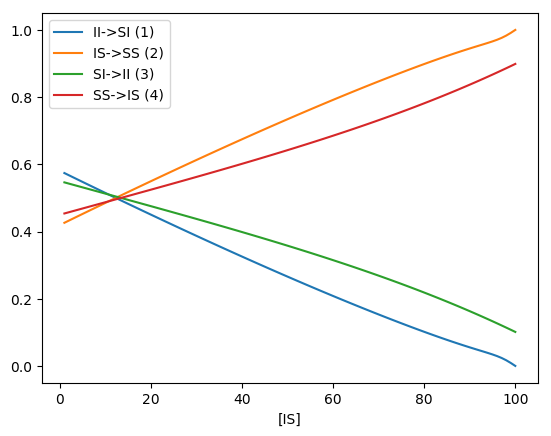

12 12


PyObject <matplotlib.text.Text object at 0x32a3d1810>

In [5]:
rates,normalized_rates,_,_,ms = get_rates_and_equilibrium(N,k,C,1/N)
for (i,central_infected) in enumerate([true,false])
    for (j,attached_infected) in enumerate([true,false])
#         if ~attached_infected 
        label=infected_combination_to_str(central_infected,attached_infected)*"->"infected_combination_to_str(~central_infected,attached_infected)
#         plot(rates[infected_combination_to_index(central_infected,attached_infected),:],label=label)
        idx = infected_combination_to_index(central_infected,attached_infected)
        plot(normalized_rates[idx,:],label=label*" ($idx)")
#         end
    end
end
legend()
xlabel("[IS]")

infected_combination_to_str (generic function with 1 method)

In [67]:
function infected_combination_to_index(b1,b2)
    idx1 = b1 ? 1 : 2
    idx2 = b2 ? 1 : 2
    return 2*(idx1-1)+idx2
end

function infected_combination_to_str(b1,b2)
    str1 = b1 ? "I" : "S"
    str2 = b2 ? "I" : "S"
    return str1*str2
end

function get_rates_and_equilibrium(N,k,C,y)
    m = N*k
    mis_range = 0:1:Int(round(min(k*N*y,k*N*(1-y))))
    rates = zeros(4,length(mis_range))

    for (l,mis) in enumerate(mis_range)
        mii = Int(round(k*N*y)) - mis
        ms = EdgeCounts(mii,mis,m,k)
#         println(ms)
        for (i,central_infected) in enumerate([true,false])
            for (j,attached_infected) in enumerate([true,false])
                m_count = Clustering.get_pair_count(ms,central_infected,attached_infected)
                rate = 0
                if m_count > 0
                    transition_fn = central_infected ? Clustering.p_i_to_s : Clustering.p_s_to_i
                    rate = m_count*transition_fn(ms,C,central_infected,attached_infected,alpha,beta)
                end
                rates[infected_combination_to_index(central_infected,attached_infected),l] = rate
            end
        end

    end

    normalized_rates = 1.0*rates
    for (l,mis) in enumerate(mis_range)
        for (i,central_infected) in enumerate([true,false])
            idx1 = infected_combination_to_index(central_infected,false)
            idx2 = infected_combination_to_index(central_infected,true)
            gamma = 1/(rates[idx1,l]+rates[idx2,l])
            indices = [idx1,idx2]
            normalized_rates[indices,l] = rates[indices,l]*gamma
        end
    end

    sol_idx = findfirst(normalized_rates[1,:] .<= normalized_rates[3,:])
    sol_idx1 = findfirst(normalized_rates[4,:] .<= normalized_rates[2,:])
    println(sol_idx," ",sol_idx1)

    mis = mis_range[sol_idx]
    mii = Int(round(k*N*y)) - mis
    ms = EdgeCounts(mii,mis,m,k)
    return rates,normalized_rates,rates[:,sol_idx],normalized_rates[:,sol_idx],ms
end

get_rates_and_equilibrium (generic function with 1 method)

In [68]:
N = 10000
k = 10
C = 0.5#(k-1)/N #0.05
# y = 0.95
m = k*N



100000

In [69]:
# y_range = collect(0.01:0.04:0.99)
y_range = logspace(log10(1/N),log10(0.99),100)
dyp = zeros(y_range)
dym = zeros(y_range)
ms_range = EdgeCounts[]
for (i,y_curr) in enumerate(y_range)
    _,_,rates,normalized_rates,ms = get_rates_and_equilibrium(N,k,C,y_curr)
    for central_infected in [true,false]
        idx1 = infected_combination_to_index(central_infected,false)
        idx2 = infected_combination_to_index(central_infected,true)
        if central_infected
            dym[i] = rates[idx1] + rates[idx2]
        else
            dyp[i] = rates[idx1] + rates[idx2]
        end
    end
    push!(ms_range,ms)
end

3 3
3 3
3 3
3 3
3 3
3 3
3 3
4 4
4 4
4 4
4 4
5 5
5 5
5 5
5 5
6 6
6 6
7 7
7 7
8 8
8 8
9 9
10 10
11 11
11 11
12 12
14 14
15 15
16 16
17 17
19 19
21 21
23 23
25 25
27 27
29 29
32 32
35 35
38 38
42 42
46 46
50 50
55 55
60 60
65 65
71 71
78 78
86 86
94 94
103 103
113 113
123 123
135 135
148 148
162 162
177 177
194 194
213 213
233 233
255 255
279 279
306 306
335 335
366 366
401 401
438 438
480 480
524 524
573 573
626 626
683 683
746 746
813 813
886 886
965 965
1050 1050
1142 1142
1240 1240
1344 1344
1456 1456
1574 1574
1698 1698
1828 1828
1963 1963
2101 2101
2240 2240
2379 2379
2512 2512
2636 2636
2744 2744
2828 2828
2880 2880
2886 2886
2831 2831
2700 2700
2470 2470
2121 2121
1627 1627
964 964
107 107


In [70]:
s_arr = (dyp-dym)
splus_arr = (dyp+dym)
# plot(y_range,(dyp-dym)./(dyp+dym))
using Dierckx
interpolation_order = 3
s_fn(x) = evaluate(Spline1D(y_range,s_arr,k=interpolation_order,bc="extrapolate"),x)
splus_fn(x) = evaluate(Spline1D(y_range,splus_arr,k=interpolation_order,bc="extrapolate"),x)
yy = y_range
pp = P_reach_fast(s_fn,splus_fn,N,1.0/N,yy)


100-element Array{Float64,1}:
 1.0     
 0.921565
 0.85023 
 0.785373
 0.726418
 0.67285 
 0.62419 
 0.580013
 0.539921
 0.503564
 0.470619
 0.4408  
 0.413841
 ⋮       
 0.221384
 0.221384
 0.221384
 0.221384
 0.221384
 0.221384
 0.221384
 0.221384
 0.221384
 0.221384
 0.221384
 0.221384

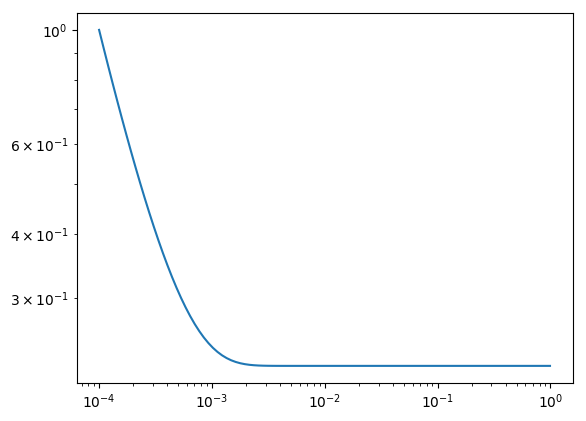

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x334e34350>

In [71]:
loglog(yy,pp)
# loglog(yy,1./(yy*N))

In [65]:
miis,miss,msss,ns = get_individual_arrays(ms_range)
z_a,z_ab,z_abm = get_z_arrays(ms_range,C,false,true)

([0.00010001,0.000110012,0.000120014,0.000130017,0.000150023,0.000160026,0.000170029,0.000190036,0.000210044,0.000230053  …  0.0512556,0.0562829,0.0617437,0.0676456,0.0740594,0.0809516,0.088492,0.0970099,0.108625,0.206],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.495485,0.498138,0.501052,0.504242,0.507726,0.511512,0.515638,0.520195,0.525761,0.5569],[5.0005e-5,5.50061e-5,6.00072e-5,6.50085e-5,7.50113e-5,8.00128e-5,8.50145e-5,9.50181e-5,0.000105022,0.000115026  …  0.27337,0.27721,0.281398,0.285944,0.290893,0.296232,0.302065,0.308603,0.317193,0.38145])

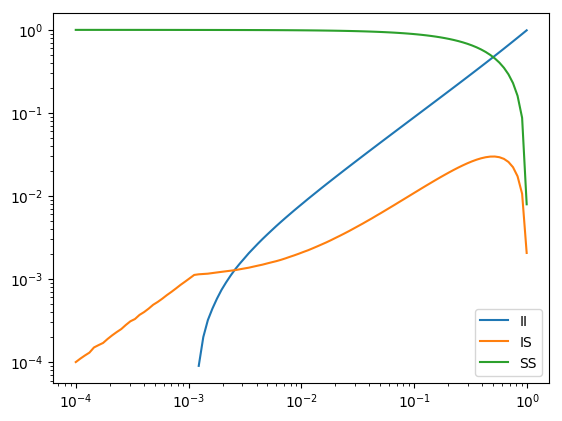

PyObject <matplotlib.legend.Legend object at 0x334df6710>

In [66]:
plot(y_range,miis/m,label="II")
plot(y_range,miss/m,label="IS")
plot(y_range,msss/m,label="SS")
loglog([],[])
legend()